# Ноутбук по проекту RDS-4 "Компьютер говорит "НЕТ" (Соколова Юлия)


# 1. Импорт библиотек
---

In [48]:
import numpy as np 
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'


import warnings
warnings.filterwarnings("ignore")

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [49]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 2. Создание функций пользователя и их описание
---

Для удобства и универсальности были созданы следующие функции (можно было бы спрятать их в модуль):

* ***my_describe*** - отображает описательные статистики в удобной для меня форме;
* ***show_heatmap*** - отображает связь между признаками на тепловой карте;
* ***show_plot_boxplot*** - строит гистограмму по столбцу и boxplot, показывает на нем среднее;
* ***all_metrics*** - выводит в виде датафрейма значения основных метрик классификации;
* ***show_roc_curve*** - отображает ROC-кривую;
* ***show_confusion_matrix*** - отображает confusion-матрицу;

In [50]:
def my_describe(df):
    """Отображение описательных статистик датафрейма в удобной форме"""
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values 
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return

In [51]:
def show_plot_boxplot(df, col_name, bins=10):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBu')(0.95)
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (10, 5)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df, bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака '"+col_name+"'", color = color_text, fontsize=14)
    axes[1].boxplot(df, vert=False, showmeans = True)
    axes[1].set_title('')
    return

In [52]:
def show_heatmap(title, df, font_scale=1):
    """Отображение связи между признаками на тепловой карте"""
    plt.style.use('seaborn-paper')
    fig, ax = plt.subplots(figsize=(10, 10))
    color_text = plt.get_cmap('PuBu')(0.95)
    sns.set(font_scale=font_scale, style='whitegrid')
    plt.subplot(111)
    h = sns.heatmap(df.corr(), annot = True, cmap= "PuBu", center= 0, fmt='.1g')
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    h.set_title(title,  fontsize=16, color = color_text)
    return

In [53]:
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)   

In [54]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [55]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Дефолтный', 'НЕ дефолтный']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

# 3. Загрузка данных
---

> $train$ - данные для обучения модели; $test$ - данные для тестирования модели

Имеется информация из анкетных данных заемщиков и факт наличия дефолта. Описание полей:
* *client_id* - идентификатор клиента
* *education* - уровень образования
* *sex* - пол заемщика
* *age* - возраст заемщика
* *car* - флаг наличия автомобиля
* *car_type* - флаг автомобиля иномарки
* *decline_app_cnt* - количество отказанных прошлых заявок
* *good_work* - флаг наличия “хорошей” работы
* *bki_request_cnt* - количество запросов в БКИ
* *home_address* - категоризатор домашнего адреса
* *work_address* - категоризатор рабочего адреса
* *income* - доход заемщика
* *foreign_passport* - наличие загранпаспорта
* *sna* - связь заемщика с клиентами банка
* *first_time* - давность наличия информации о заемщике
* *score_bki* - скоринговый балл по данным из БКИ
* *region_rating* - рейтинг региона
* *app_date* - дата подачи заявки
* *default* - флаг дефолта по кредиту

In [56]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [57]:
print(f'Размерность тренировочного датасета: {train.shape[0]} записей и {train.shape[1]} признаков.')
print(f'Размерность тестового датасета: {test.shape[0]} записей и {test.shape[1]} признаков.')

Размерность тренировочного датасета: 73799 записей и 19 признаков.
Размерность тестового датасета: 36349 записей и 18 признаков.


# 4. Предварительный анализ данных
---

In [58]:
# Смотрим описательные характеристики тренировочного датасета
my_describe(train)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,client_id,int64,73799,0,73799,1,110147,55138,55274
1,app_date,object,73799,0,120,NaN,NaN,NaN,NaN
2,education,object,73492,307,5,NaN,NaN,NaN,NaN
3,sex,object,73799,0,2,NaN,NaN,NaN,NaN
4,age,int64,73799,0,52,21,72,39.2806,37
5,car,object,73799,0,2,NaN,NaN,NaN,NaN
6,car_type,object,73799,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,73799,0,21,0,33,0.275749,0
8,good_work,int64,73799,0,2,0,1,0.164894,0
9,score_bki,float64,73799,0,69096,-3.62459,0.199773,-1.90472,-1.92082


In [59]:
# Смотрим описательные характеристики тестового датасета
my_describe(test)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,client_id,int64,36349,0,36349,4,110148,54945.6,54657
1,app_date,object,36349,0,120,NaN,NaN,NaN,NaN
2,education,object,36178,171,5,NaN,NaN,NaN,NaN
3,sex,object,36349,0,2,NaN,NaN,NaN,NaN
4,age,int64,36349,0,51,21,71,39.186,37
5,car,object,36349,0,2,NaN,NaN,NaN,NaN
6,car_type,object,36349,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,36349,0,19,0,30,0.26804,0
8,good_work,int64,36349,0,2,0,1,0.166772,0
9,score_bki,float64,36349,0,34287,-3.5742,0.18882,-1.90415,-1.92082


In [60]:
# Сохрания ID клиентов из тестового набора для последующего формирования Submission
id_test = test.client_id

**Резюме**: в тренировочном наборе 73799 записей о кредитной истории, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая):
- *client_id* -идентификатор клиента, не нужная переменная;
- *app_date* - временная переменная;
- *sex*, *car*, *car_type*, *good_work*, *foreign_passport* - бинарные переменные;
- *education*, *region_rating*, *home_address*, *work_address*, *sna*, *first_time* - категориальные переменные;
- *age*, *decline_app_cnt*, *score_bki*, *bki_request_cnt*, *income* - числовые переменные;
- *default* - целевая переменная, индикатор дефолта.

Всего пропусков: 307+171 (307 - в наборе train, 171 - в наборе test), все пропуски в переменной ***education***. Столбец ***client_id*** содержит числовой признак клиента, который не несет полезной для модели информации. В бинарном признаке ***default*** - целевая переменная, индикатор дефолта по кредиту (0 - не обнаружен, 1 - дефлот обнаружен).

# 5. Feature Engineering
___
## 5.1. Обработка пропусков

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима **предварительная очистка данных**.

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

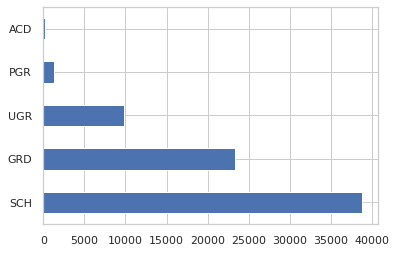

In [61]:
train['education'].value_counts().plot.barh()

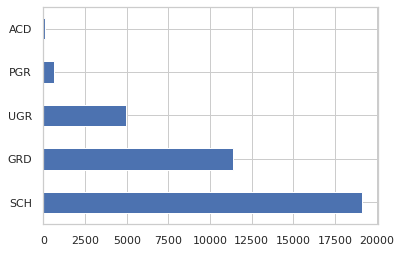

In [62]:
test['education'].value_counts().plot.barh()

In [63]:
# заполним пропуски в education самым популярным значением (по наборам train, test)
fill_value = train['education'].value_counts().index[0]
train['education'].fillna(fill_value, inplace=True)

fill_value = test['education'].value_counts().index[0]
test['education'].fillna(fill_value, inplace=True)

In [64]:
# Проверим успешность заполнения пропусков для тренировочного набора
print('Всего пропусков на наборе train:', train.isna().sum().sum())
# Проверим успешность заполнения пропусков для тестового набора
print('Всего пропусков на наборе test:', test.isna().sum().sum())

Всего пропусков на наборе train: 0
Всего пропусков на наборе test: 0


## 5.2. Анализ переменных

In [65]:
# Создадим списки переменных (client_id не включаем в списки)
# временная переменная
time_cols = ['app_date']

# бинарные переменные (default - целевой признак, не включаем в список)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные 
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

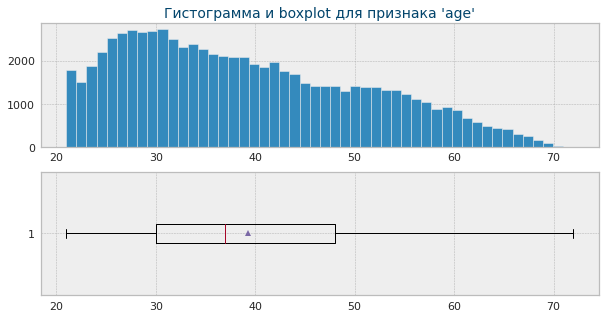

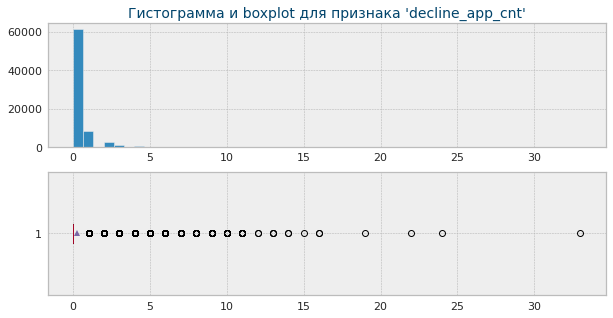

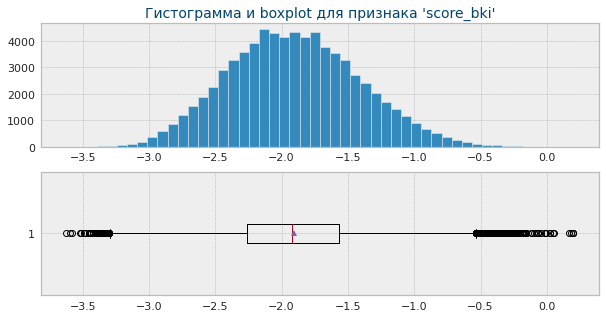

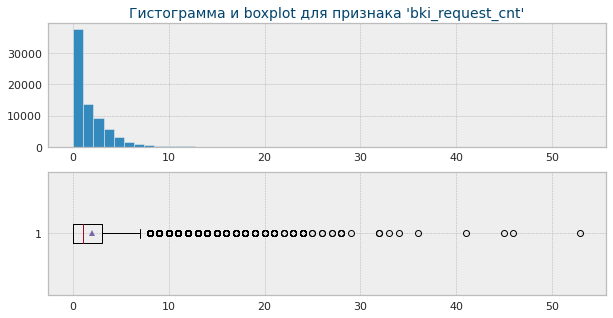

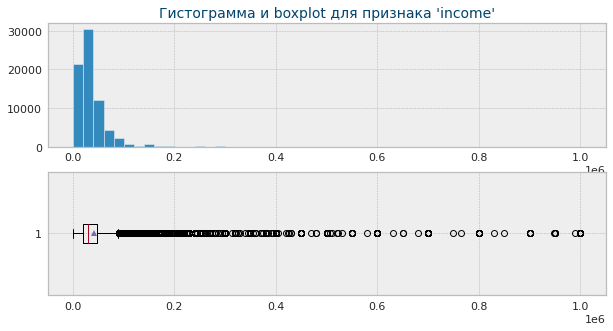

In [66]:
# Посмотрим на распределение и boxplot’ы для численных переменных.
for col in num_cols:
    show_plot_boxplot(train[col], col, bins=50)

## 5.3. Log-преобразование

После построения гистограмм стало очевидно, что распределения числовых переменных 'age', 'decline_app_cnt', 'bki_request_cnt', 'income' имеют тяжёлый правый хвост, кроме того, почти все числовые признаки (кроме 'age') содержат выбросы, к которым чувствительна LogisticRegression. 

> Для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей.

Анализ распределений и boxplot-ов показывает, что признак 'score_bki' может быть как положительным, так и отрицательным, его логарифмировать напрямую нельзя, но его распределение и так похоже на нормальное.
Возьмем логарифм от числовых признаков 'age', 'decline_app_cnt', 'bki_request_cnt', 'income' и построим графики распределения логарифмированных переменных, потом оценим выбросы.


In [67]:
temp_list = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in temp_list:
    train[col] = np.log(train[col] + 1)
    test[col] = np.log(test[col] + 1)

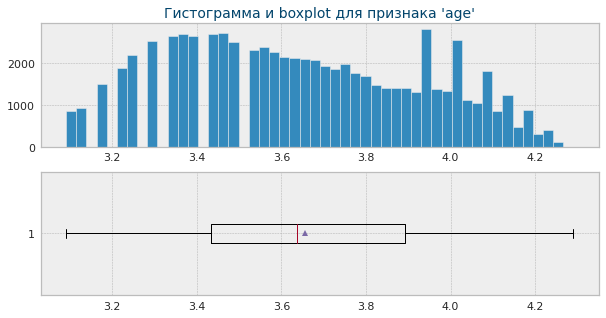

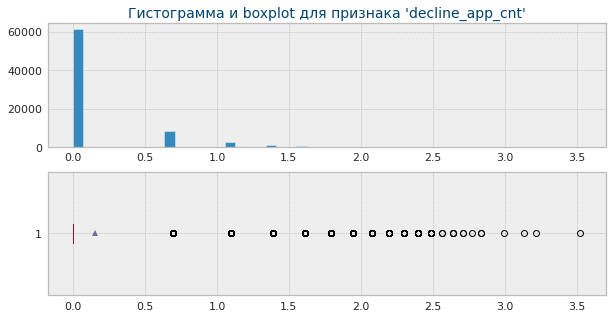

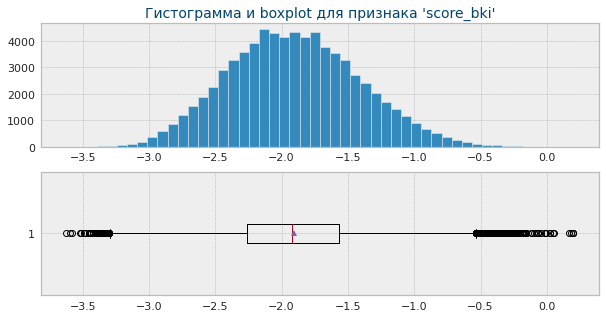

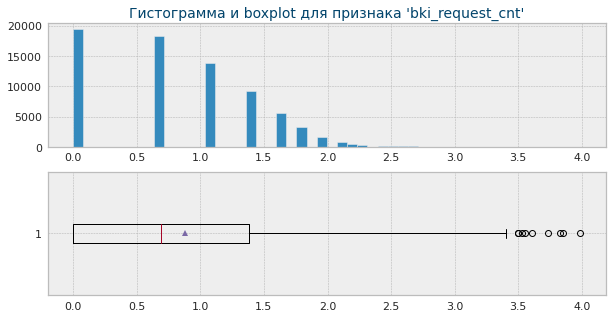

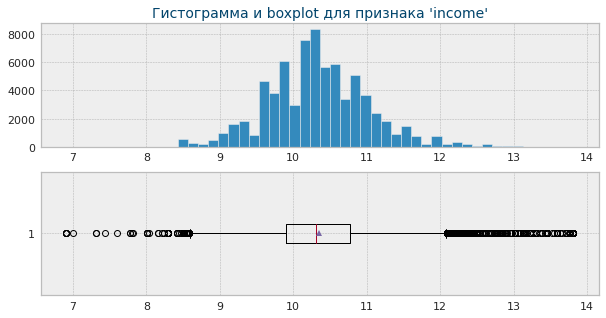

In [68]:
# Посмотрим на распределение и boxplot’ы для численных переменных после логарифмирования
for col in num_cols:
    show_plot_boxplot(train[col], col, bins=50)

После логарифмирования некоторые переменные стали менее смещёнными. Такой принцип можно применить перед построением модели.

Выбросов стало заметно меньше. Пока их не будем трогать, вернемся к вопросу об их удалении потом.

## 5.4. Преобразование временной переменной

Проанализируем значения в столбце ***app_date*** - дата подачи заявки

In [69]:
train.app_date.sample(5), test.app_date.sample(5)

(34974    22FEB2014
 33074    15APR2014
 71319    03FEB2014
 56735    04APR2014
 50243    16MAR2014
 Name: app_date, dtype: object,
 4079     16MAR2014
 17721    20MAR2014
 17541    17JAN2014
 7714     21MAR2014
 4638     07APR2014
 Name: app_date, dtype: object)

In [70]:
# Преобразуем признак app_date в нужный формат
train.app_date = pd.to_datetime(train.app_date, format='%d%b%Y')
test.app_date = pd.to_datetime(test.app_date, format='%d%b%Y')
train.app_date.sample(5), test.app_date.sample(5),

(53529   2014-01-27
 23876   2014-04-10
 45327   2014-02-21
 30838   2014-04-15
 10326   2014-03-11
 Name: app_date, dtype: datetime64[ns],
 4801    2014-04-30
 23301   2014-04-08
 29190   2014-02-02
 14593   2014-03-17
 17097   2014-01-07
 Name: app_date, dtype: datetime64[ns])

In [71]:
# Определим дату самой ранней заявки в датасетах
data_start = min(train.app_date.min(), test.app_date.min())
data_start

Timestamp('2014-01-01 00:00:00')

Дата подачи самой первой заявки - 01 января 2014г.

Создадим новый столбец **delta_deys**, в котором будет записана разница между датой, указанной в столбце **app_date** и датой подачи первой заявки (01.01.2014). Включим этот столбец в состав числовых.

In [72]:
train['delta_deys'] = (train.app_date - data_start).dt.days.astype('int')
test['delta_deys'] = (test.app_date - data_start).dt.days.astype('int')
num_cols.append('delta_deys')

Не числовой столбец **app_date** удалим из обоих наборов (учебного и тестового) 

In [73]:
train.drop(['app_date'], axis=1, inplace=True)
test.drop(['app_date'], axis=1, inplace=True)

## 5.5 Оценка корреляций

Оценим корреляцию Пирсона для непрерывных переменных. Помним, что сильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

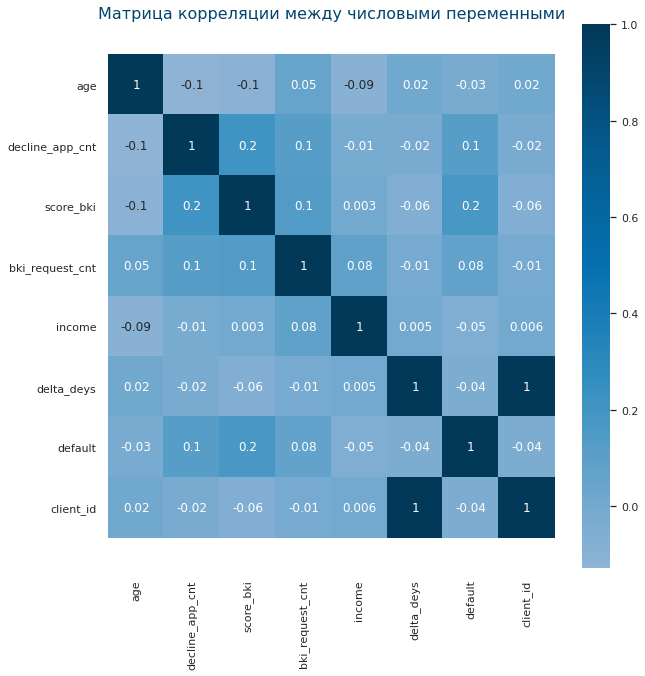

In [74]:
corr_list = num_cols+['default']+['client_id']
show_heatmap('Матрица корреляции между числовыми переменными', train[corr_list])

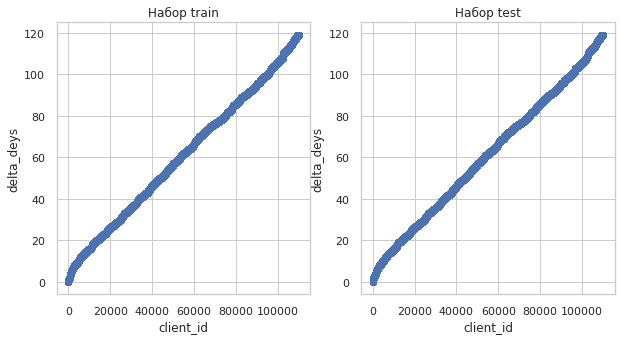

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(x=train['client_id'], y=train['delta_deys'], marker='o')
axes[0].set_xlabel('client_id')
axes[0].set_ylabel('delta_deys')
axes[0].set_title('Набор train')
axes[1].scatter(x=test['client_id'], y=test['delta_deys'], marker='o')
axes[1].set_xlabel('client_id')
axes[1].set_ylabel('delta_deys')
axes[1].set_title('Набор test')
plt.show();

По графикам можно сделать вывод, что в банке нумерация клиентов велась в зависимости от дня обращения.
Эти признаки будут сильно скоррелированными.

Видно, что скоррелированными являются признаки **client_id** и **delta_deys**. Удалим **client_id** и избавимся от мультиколлинеарности. В рестовом наборе **client_id** оставим, чтобы потом записать результаты по **client_id**.


In [76]:
train.drop(['client_id'], axis=1, inplace=True)

Больше сильно скорелированных между собой признаков нет, поэтому все будем использовать при построении модели.

Построим **boxplot**’ы для численных переменных для сравнения дефолтных и недефолтных заемщиков.

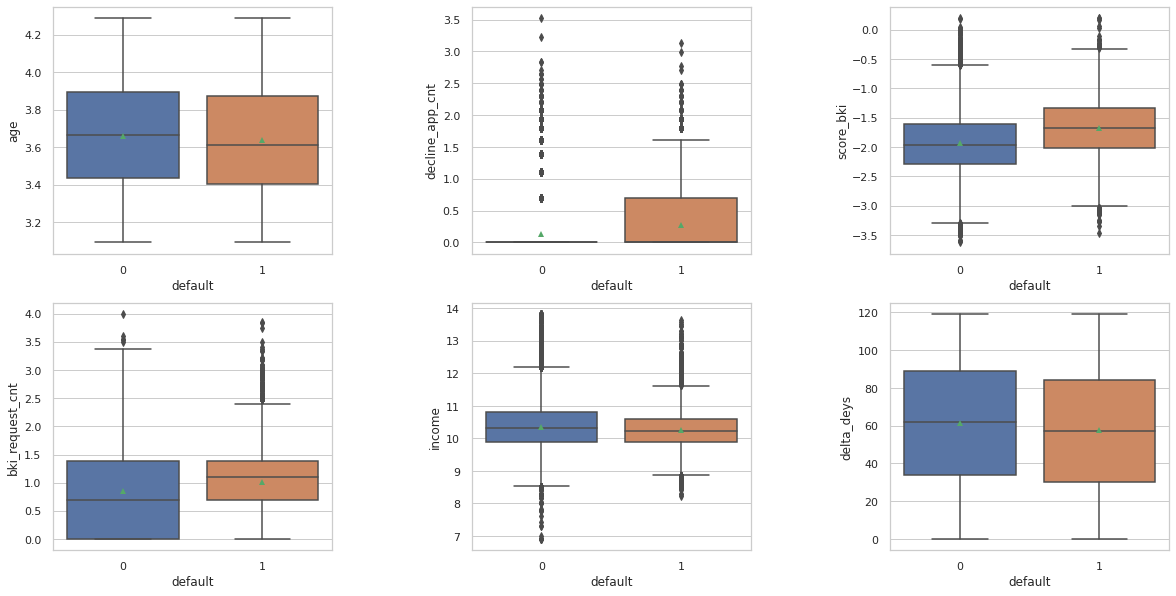

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=train, orient = 'v', ax=axes[i], showfliers=True,  showmeans = True)

***Выводы (анализ boxplot-ов) для числовых переменных***:
* **age**: дефолтные клиенты в среднем младше
* **decline_app_cnt**: дефолтные клиенты в среднем имеют большее количество отмененных заявок
* **score_bki**: дефолтные клиенты в среднем имеют больший скоринговый балл по данным из БКИ
* **bki_request_cnt**: дефолтные клиенты в среднем имеют больше запросов в БКИ
* **income**: дефолтные клиенты в среднем имеют более низкий доход
* **delta_deys**: дефолтные клиенты в среднем обращались ранее

### Значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA))

Для оценки значимости числовых переменных будем использовать функцию **f_classif** из библиотеки **sklearn**.

В качестве меры значимости мы будем использовать значение  ***f*** -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

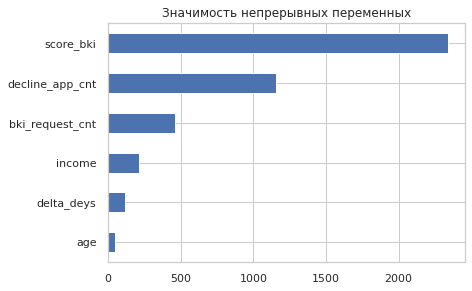

In [78]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных')

**Выводы по оценке значимости**: **score_bki** (оценка плательщика БКИ) - самый значимый показатель по ANOVA f-test, следующий по значимости **declain_app_cnt** (кол-во отказанных заявок),на третьем месте -  **bki_request_cnt** (количество запросов в БКИ), в конце - **age** (возраст).

## 5.5. Преобразование бинарных переменных¶

Убедимся в том, что в бинарных переменных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport') записано всего два значения

In [79]:
print('Анализ бинарных признаков учебного датасета')
for col in bin_cols:
    print(f'Уникальные записи в столбце {col}:')
    print(train[col].value_counts())

Анализ бинарных признаков учебного датасета
Уникальные записи в столбце sex:
F    41562
M    32237
Name: sex, dtype: int64
Уникальные записи в столбце car:
N    49832
Y    23967
Name: car, dtype: int64
Уникальные записи в столбце car_type:
N    59791
Y    14008
Name: car_type, dtype: int64
Уникальные записи в столбце good_work:
0    61630
1    12169
Name: good_work, dtype: int64
Уникальные записи в столбце foreign_passport:
N    62733
Y    11066
Name: foreign_passport, dtype: int64


In [80]:
print('Анализ бинарных признаков тестового датасета')
for col in bin_cols:
    print(f'Уникальные записи в столбце {col}:')
    print(train[col].value_counts())

Анализ бинарных признаков тестового датасета
Уникальные записи в столбце sex:
F    41562
M    32237
Name: sex, dtype: int64
Уникальные записи в столбце car:
N    49832
Y    23967
Name: car, dtype: int64
Уникальные записи в столбце car_type:
N    59791
Y    14008
Name: car_type, dtype: int64
Уникальные записи в столбце good_work:
0    61630
1    12169
Name: good_work, dtype: int64
Уникальные записи в столбце foreign_passport:
N    62733
Y    11066
Name: foreign_passport, dtype: int64


Преобразуем бинарные переменные при помощи класса **LabelEncoder**. Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.

In [81]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for col in bin_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
    
# Убедимся в преобразовании    
train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,delta_deys
0,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,31
1,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,70
2,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,31
3,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,22
4,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,107


### 5.6. Преобразование категориальных переменных

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа...

Для оценки значимости категориальных и бинарных переменных будем использовать функцию *mutual_info_classif* из библиотеки *sklearn*.
*mutual_info_classif* сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями, и нам в этом помешает *education* столбец. Преобразем этот признак в численный формат, а затем определим важность признаков.

In [82]:
label_encoder = LabelEncoder()
train['education'] = label_encoder.fit_transform(train['education'])
test['education'] = label_encoder.fit_transform(test['education'])

### Значимость категориальных  и бинарных переменных признаков

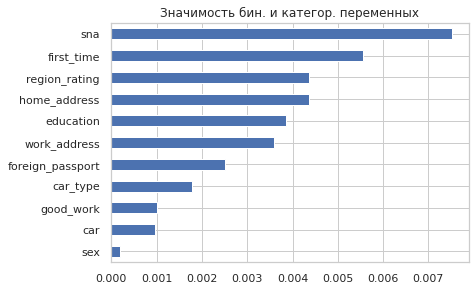

In [83]:
# Определим важность признаков
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных')

Визуализация важности признаков показывает, что самым значимым из категориальных и бинарных является признак *sna*, а наименее важным по мнению *mutual_info_classif* является признак *sex*.

## 5.7. Определение дисбаланса классов
Посмотрим, каких клиентов у банка больше: дефолтных или добросовестных

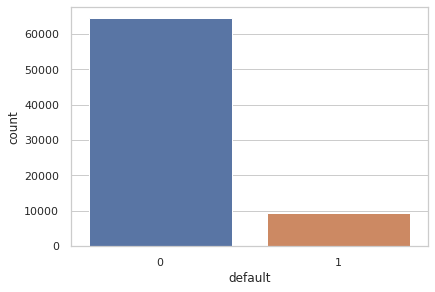

In [84]:
sns.countplot(train['default']);

In [85]:
# Посмотрим на данные
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73799 non-null  int64  
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  float64
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

# 6. Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

## 6.1.  One Hot Encoding 


In [86]:
# Реализуем метод  One Hot Encoding через get_dummies
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

## 6.2.  Стандартизация (StandardScaler)
Стандартизацию проводим отдельно для трейна и теста

In [87]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)

# Объединяем
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y = train['default'].values

In [88]:
# Проверяем размеры наборов train и test
train.shape, test.shape, X.shape, Test.shape

((73799, 18), (36349, 18), (73799, 37), (36349, 37))

# 7. Построение модели

## 7.1. Первая модель (хоть как-то)

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,41.000000,Истинно дефолтные
TN,12871.000000,Истинно НЕ дефолтные
FP,62.000000,Ложно дефолтные
FN,1786.000000,Ложно НЕ дефолтные
Accuracy,0.874797,Accuracy=(TP+TN)/(P+N)
Precision,0.398058,Точность = TP/(TP+FP)
Recall,0.022441,Полнота = TP/P
F1-score,0.042487,Среднее гармоническое Precision и Recall


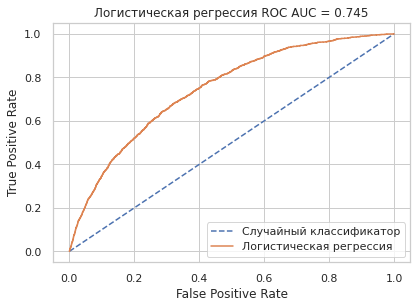

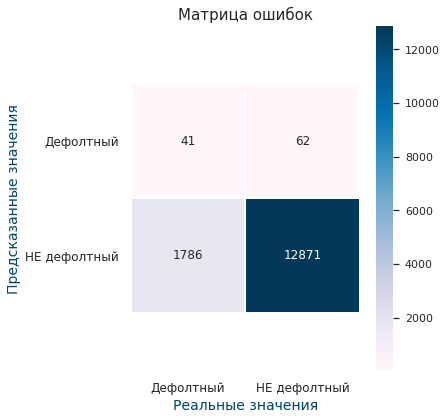

In [89]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_1 = LogisticRegression(random_state=RANDOM_SEED)

model_1.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_1.predict_proba(X_test)[:,1]
y_pred = model_1.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

**ВЫВОДЫ**: Абсолютно не угадали дефолтных клиентов. Несмотря на то, что ROC-AUC высокий (эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных). Значение точности, полноты и f1 сигнализирует о том что что-то не в порядке. Построенная модель очень плохая: из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (41 из 1827). Это показывает и метрика recall = 0.02244. Таким образом, на основе выводов модели будем выдавать кредиты людям которые их не смогут вернуть - риск потерять все деньги.


## 7.2. Вторая модель
Попробуем выполнить нормировку с помощью RobastScaler, которая при нормализации использует  медианы, квантили, и поэтому не чувствительна с выбросам и может приводить к лучшим результатам.

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,41.000000,Истинно дефолтные
TN,12872.000000,Истинно НЕ дефолтные
FP,61.000000,Ложно дефолтные
FN,1786.000000,Ложно НЕ дефолтные
Accuracy,0.874864,Accuracy=(TP+TN)/(P+N)
Precision,0.401961,Точность = TP/(TP+FP)
Recall,0.022441,Полнота = TP/P
F1-score,0.042509,Среднее гармоническое Precision и Recall


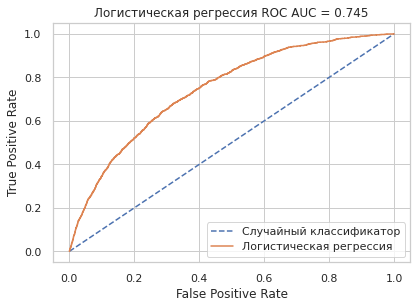

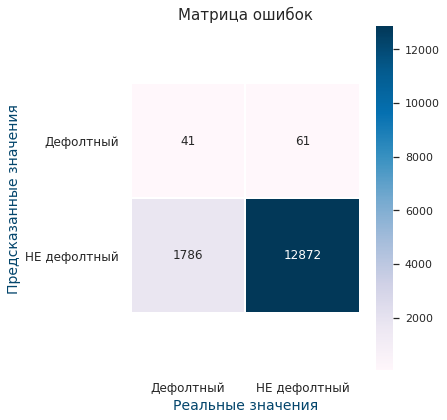

In [90]:
# RobastScaler
X_num = RobustScaler().fit_transform(train[num_cols].values)
X_num_test = RobustScaler().fit_transform(test[num_cols].values)

# Объединяем
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y = train['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_2 = LogisticRegression(random_state=RANDOM_SEED)

model_2.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

**ВЫВОДЫ**: RobustScaler не улучшил качество модели.

## 7.3. Третья модель

In [91]:
C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model = LogisticRegression(random_state=RANDOM_SEED)

# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'class_weight': ['none', 'balanced'],
                          'max_iter': [50], 'multi_class': ['auto', 'ovr'],
                          'penalty': ['l1'], 'so...
                          'tol': [0.001]},
                         {'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'class_weight': ['none', 'balanced'],
                          'max_iter': [50], 'multi_class': ['auto', 'ovr'],
                          'penalty': ['none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']

In [92]:
# Смотрим лучшие гиперпараметры
model_3 = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_3.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

# Предсказываем
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

Лучшие значения параметров:
  C => 1291.5496650148827
  class_weight => balanced
  dual => False
  fit_intercept => True
  intercept_scaling => 1
  l1_ratio => None
  max_iter => 50
  multi_class => auto
  n_jobs => None
  penalty => l2
  random_state => 42
  solver => sag
  tol => 0.001
  verbose => 0
  warm_start => False


,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,1256.000000,Истинно дефолтные
TN,8647.000000,Истинно НЕ дефолтные
FP,4286.000000,Ложно дефолтные
FN,571.000000,Ложно НЕ дефолтные
Accuracy,0.670935,Accuracy=(TP+TN)/(P+N)
Precision,0.226633,Точность = TP/(TP+FP)
Recall,0.687466,Полнота = TP/P
F1-score,0.340888,Среднее гармоническое Precision и Recall


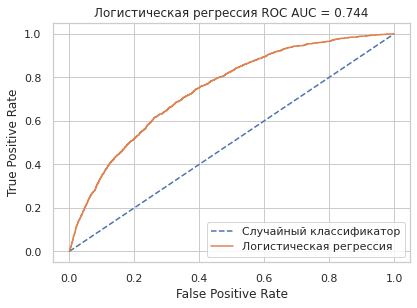

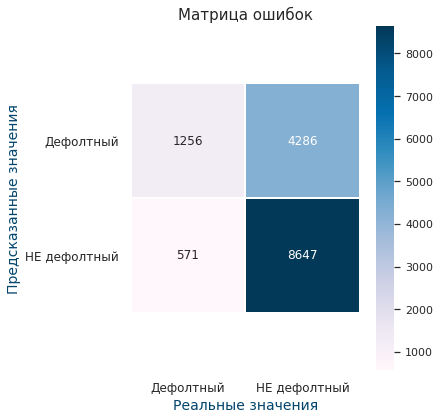

In [93]:
# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

**ВЫВОДЫ**: Построенная модель по сравнению с первой уже лучше определяет дефолтных клиентов, но в ней увеличилась ошибка распознавания не дефолтных клиентов. В такой ситуации банк рискует недополучить прибыль. Удалось увеличить показания Recall и Precision.

# 8. Submission

По ходу анализа абора **train** соответствующие действия производились с набором **test**:
* заполнили пропуски в **test.education** самым популярным значением;
* преобразовали признак **app_date** (дата подачи заявки) в нужный формат;
* возяли логарифм от числовых признаков **age**, **decline_app_cnt**, **bki_request_cnt**, **income**
* создали новый столбец **delta_deys**, в котором будет записана разница между датой, указанной в столбце **app_date** и датой подачи первой заявки (01.01.2014);
* удалили из тестового набора не числовой столбец **app_date**;
* преобразовали бинарные переменные при помощи класса LabelEncoder;
* преобразовали  признак **education** в численный формат;
* стандартизировали числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных

In [94]:
submission_pred_prob = model_3.predict_proba(Test)[:,1]
submission_predict = model_3.predict(Test)

submission = pd.DataFrame({'client_id': id_test, 
                            'default': submission_pred_prob})
submission.to_csv('submission.csv', index=False)

submission

,client_id,default
0,74835,0.204954
1,17527,0.791000
2,75683,0.301122
3,26883,0.411916
4,28862,0.139382
...,...,...
36344,83775,0.766093
36345,106254,0.118487
36346,81852,0.779943
36347,1971,0.623754


P.S. В рамках 48 часов получилось повторить то, что было рекомендовано приподготовка (банально повторила), не удалось: 
* убрать выбросы и проверить качество;
* убрать не значимые признаки и проверить качество;
* сгенерировать новые признаки и посмотреть на улучшение;
* избавиться от дисбаланса классов и посмотреть на улучшение;
* еще что-нибудь прикрутить для решения задачи.